# Implement a custom Autoencoder with Koopman layer

## Version Control

Short Term To Do:
1) Consider output activation function to be more robust than
2) Plot eigenfunctions & save
3) Constraining K
4) Validation data has different batch size. Address when HP training

Long Term To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
7) Change training inference vs testing inference


## Setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time 
import os

In [2]:
# Import hyperparameter tuning
import keras_tuner as kt
hp = kt.HyperParameters()

In [3]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

In [5]:
doggo_train = pd.read_csv('Rigid Ground Data/train_data.csv', sep=',').values
doggo_test =pd.read_csv('Rigid Ground Data/test_data.csv', sep=',').values
doggo_validation = pd.read_csv('Rigid Ground Data/validation_data.csv', sep=',').values

In [6]:
input_dim = 4
output_dim = 4

doggo_train = doggo_train[:,0:input_dim]
doggo_test = doggo_test[:,0:input_dim]
doggo_validation = doggo_validation[:,0:input_dim]

In [7]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 16 #total number of trajectories in the dataset
numTraj_val = 4
batch_size = int(256) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 4

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

In [8]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(doggo_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

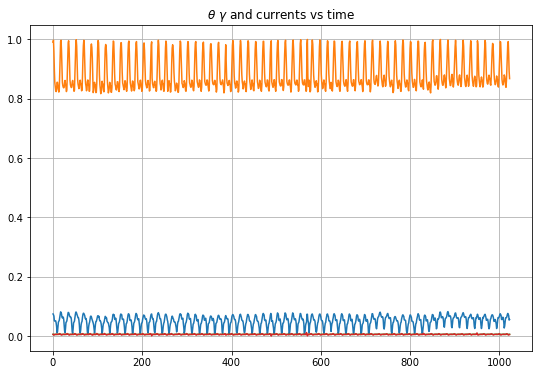

In [9]:
x_train = train_data
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title(r"$\theta$ $\gamma$ and currents vs time")
plt.show()

## Define the model

### Encoder

In [10]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [11]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc0 = EncoderLayer(16)
        self.enc1 = EncoderLayer(32)
        self.enc2 = EncoderLayer(64)
        self.enc3 = EncoderLayer(64)
        self.enc4 = EncoderLayer(16)
        self.enc5 = EncoderLayer(16)
        self.outputLayer = EncoderLayer(16)

    def call(self, input):
        x = input
        x = self.enc0(x)
        x = tf.nn.tanh(x)
        x = self.enc1(x)
        x = tf.nn.tanh(x)
        x = self.enc2(x)
        x = tf.nn.tanh(x)
        x = self.enc3(x)
        x = tf.nn.tanh(x)
        x = self.enc4(x)
        x = tf.nn.tanh(x)
        x = self.enc5(x)
        x = tf.nn.tanh(x)

        # Encoder output layer
        z = self.outputLayer(x)
        z = tf.nn.tanh(z)
        return z

### Koopman

In [12]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj                 
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [13]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj , name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

### Decoder

In [14]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [15]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec0 = DecoderLayer(64)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(32)
        self.dec3 = DecoderLayer(64)
        self.outputLayer = DecoderLayer(4)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec0(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec3(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)


        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        #x_hat = tf.nn.elu(x_hat)
        #x2_hat = tf.nn.elu(x2_hat)
        #x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

### Koopman Autoencoder

In [16]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, hp, trajLength, numTraj, outputDim=2, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

## Hyperparameter Tuning

In [17]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, input_dim, batch_size, trajLength, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val


        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 


    def build(self, hp):
        koopmanAEModel = Koopman_AE_Model(hp, self.trajLength, self.numtraj_batch)
        return koopmanAEModel


    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, hp, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = hp.Float("alpha1", min_value=1e-4, max_value=1e-1, sampling="log")
        alpha2 = hp.Float("alpha2", min_value=1e-9, max_value=1e-5, sampling="log")
        alpha3 = hp.Float("alpha3", min_value=1e-17, max_value=1e-13, sampling="log")
        alpha4 = hp.Int('alpha4', min_value=1, max_value=10, step=1)

        x2 = []
        x2_SP = []
        x2_tilde_SP = []
        for i in range(self.numtraj_batch):
            predict_length = self.trajLength-1
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength]) # forward time shift x to get x2
            x2_SP.append(x[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # forward time shift x to get x2 for Sp timesteps
            #x2_tilde_SP.append(x2_tilde[i*self.trajLength:i*self.trajLength+predict_length]) # get Sp timesteps from x2_tilde
            x2_tilde_SP = x2_tilde

        x2 = tf.reshape(x2, [-1, x.shape[-1]])
        x2_SP = tf.reshape(x2_SP, [-1, x.shape[-1]])
        x2_tilde_SP = tf.reshape(x2_tilde_SP, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2_SP,x2_tilde_SP)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + alpha4*sum(model.losses)

    ###############################################  GRAPH FUNCTIONS     #########################################################


    def graphPlot(self, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_Epoch_%d" % (epochNum)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 


    ###############################################     FIT FUNCTION        #########################################################


    def fit(self, hp, model, x, y, validation_data, batch_size, callbacks=None):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        # Metric to track validation loss
        epoch_loss_metric = keras.metrics.Mean()
        epochs = 1000
        

        ############################################### TRAINING FUNCTIONS #######################################################

        def run_train_step(x_batch_train,y_batch_train):
            with tf.GradientTape() as tape:
                reconstruction, prediction, linearity = model(x_batch_train)

                # total avg loss for each batch
                batch_train_loss = self.tot_loss(hp, model, y_batch_train, reconstruction, prediction, linearity)
                batch_train_loss_list.append(batch_train_loss)

            grads = tape.gradient(batch_train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            return batch_train_loss

        def run_val_step(x_batch_val,y_batch_val):
            reconstruction_val, pred_val, linearity_val = model(x_batch_val)
            
            batch_validation_loss = self.tot_loss(hp, model, y_batch_val, reconstruction_val, pred_val, linearity_val)
            

            epoch_loss_metric.update_state(batch_validation_loss)
            return batch_validation_loss

        ################################################# LOOPING BATCHES #####################################################


        for callback in callbacks:
            callback.model = model
        
        best_epoch_val_loss = float("inf")
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        batch_train_loss_list = [] # total loss for each batch 
        batch_validation_loss_list = []

        start_time_total = time.time()
        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []
            
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                batch_train_loss = run_train_step(x_batch_train, y_batch_train)
                batch_train_loss_list.append(batch_train_loss)
        
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            epoch_train_loss.append(avg_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))
        
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                batch_validation_loss = run_val_step(x_batch_val, y_batch_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)

            # Calling the callbacks after epoch
            epoch_loss_val = float(epoch_loss_metric.result().numpy())
            
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss_val})
            epoch_loss_metric.reset_states()

            print(f"Epoch val loss: {epoch_loss_val}")
            print("Time taken: %.2fs" % (time.time() - start_time))

            best_epoch_val_loss = min(best_epoch_val_loss, epoch_loss_val)
            self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)


        self.graphPlot(epoch_train_loss, epoch_validation_loss)
        print("Total time taken: %.2fs" % (time.time() - start_time_total))
        
        # Return the evaluation metric value
        return best_epoch_val_loss

In [18]:
hypermodel = MyHyperModel(input_dim, batch_size, trajLength, num_batches_train, num_batches_val)
tuner = kt.RandomSearch(
    hypermodel=hypermodel,
    objective=kt.Objective("my_metric", "min"),
    max_trials=5,
    directory="checkpoints_HP",
    project_name="doggo_Mulch_Soil_1",
    overwrite = True,
)

In [19]:
tuner.search(x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)

Trial 5 Complete [00h 29m 59s]
my_metric: 5.717989552067593e-06

Best my_metric So Far: 3.434399786783615e-07
Total elapsed time: 02h 30m 20s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()

Results summary
Results in checkpoints_HP\doggo_Mulch_Soil_1
Showing 10 best trials
Objective(name='my_metric', direction='min')
Trial summary
Hyperparameters:
alpha1: 0.0001
alpha2: 1e-09
alpha3: 1e-17
alpha4: 1
Score: 3.434399786783615e-07
Trial summary
Hyperparameters:
alpha1: 0.002074744562528473
alpha2: 3.4582433222835536e-08
alpha3: 5.912277538167278e-14
alpha4: 2
Score: 3.03223851005896e-06
Trial summary
Hyperparameters:
alpha1: 0.0028676349142778444
alpha2: 1.1501146190088283e-09
alpha3: 1.0748431375056851e-17
alpha4: 4
Score: 5.717989552067593e-06
Trial summary
Hyperparameters:
alpha1: 0.030375164510309787
alpha2: 5.073470829851947e-07
alpha3: 4.346943993947178e-16
alpha4: 10
Score: 4.2666208173613995e-05
Trial summary
Hyperparameters:
alpha1: 0.09053206365408997
alpha2: 7.305695823828034e-08
alpha3: 1.5341114894963018e-16
alpha4: 8
Score: 8.779517520451918e-05


In [33]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'alpha1': 0.0001, 'alpha2': 1e-09, 'alpha3': 1e-17, 'alpha4': 1}


In [22]:
best_model = tuner.get_best_models()[0]
out1, out2, out3 = best_model(train_data)
best_model.summary()

Model: "koopman_ae__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  8480      
_________________________________________________________________
koopman__model (Koopman_Mode multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  9700      
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


# Save best model

In [23]:
best_model.save('checkpoints/doggo_HP_Mulch_Soil')

INFO:tensorflow:Assets written to: checkpoints/doggo_HP_Mulch_Soil\assets


# Load saved model

In [24]:
new_model = tf.keras.models.load_model('checkpoints/doggo_HP_Mulch_Soil', compile=False)
new_model.summary()

Model: "koopman_ae__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  8480      
_________________________________________________________________
koopman__model (Koopman_Mode multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  9700      
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


# Plots on Train data

### Reconstruction

In [25]:
input = x_train
out1, out2, out3 = new_model(input)

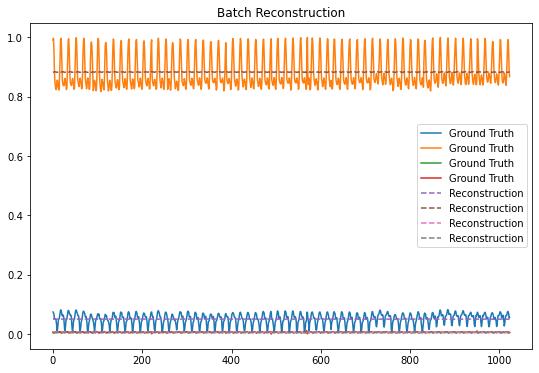

In [26]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(out1, '--', label="Reconstruction")
plt.legend()

### Linear Prediction

In [27]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

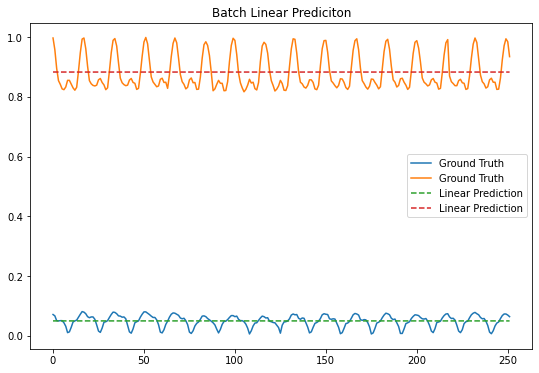

In [28]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,0:2], label = "Ground Truth")
plt.plot(out3[:,0:2], '--', label="Linear Prediction")
plt.legend()

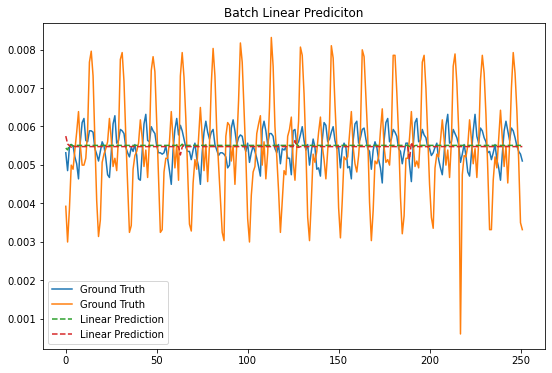

In [29]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,2:4], label = "Ground Truth")
plt.plot(out3[:,2:4], '--', label="Linear Prediction")
plt.legend()

### Error graphs

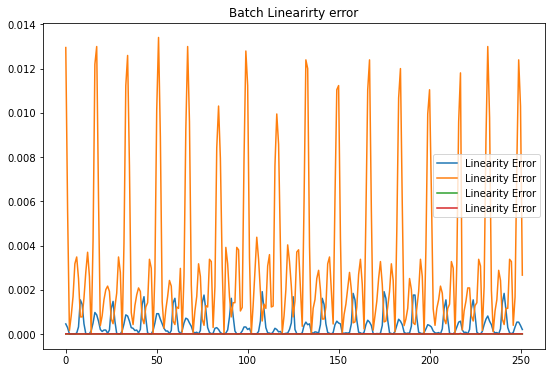

In [30]:
plt.title("Batch Linearirty error")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot((tf.square(tf.subtract(x2,out3))), label = "Linearity Error")
plt.legend()

### Koopman Matrix

In [31]:
K = new_model.koopman.get_weights()
print(K)

[array([[-1.10946838e-02,  1.24832513e-02, -7.34294951e-02,
         1.40965832e-02,  4.22912203e-02,  2.53603258e-03,
        -2.89678182e-02, -5.69339097e-03, -3.76372598e-02,
        -7.20712543e-02, -5.18741123e-02,  4.15518321e-02,
         1.93664711e-02,  2.39029154e-02,  9.83810574e-02,
         4.23039086e-02],
       [-2.08788700e-02,  7.86577258e-03,  4.90177572e-02,
        -1.01342693e-01,  8.50069709e-03,  2.44571529e-02,
        -6.15482358e-03, -1.87528860e-02, -2.32633520e-02,
        -2.25709435e-02,  2.75207218e-02,  1.12188887e-02,
         2.35537216e-02,  1.00186221e-01, -6.92575937e-03,
         1.44318193e-02],
       [-2.45135892e-02,  2.29542702e-02, -1.19466856e-01,
        -2.50736475e-02, -2.18200926e-02,  3.11928168e-02,
         4.33419161e-02,  1.95864346e-02,  4.69894595e-02,
         1.65296141e-02, -2.64837071e-02,  1.10573601e-02,
         4.16545868e-02, -4.06189524e-02, -2.77275108e-02,
         8.92496109e-02],
       [ 1.04856417e-02, -5.40320128